In [93]:
import pandas as pd
import numpy as np

filepath = '../../data/processed/yp_competitors_rws_0001_0050_topics.csv'
filepath_hi = '../../data/processed/hi_rws_0001_0256_topics.csv'
df = pd.read_csv(filepath_hi)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 9 columns):
hdp_logentropy_topic_mode                 50 non-null int64
hdp_logentropy_topic_mode_prob            50 non-null object
hdp_logentropy_topic_list                 50 non-null object
hdp_tfidf_topic_mode                      50 non-null int64
hdp_tfidf_topic_mode_prob                 50 non-null object
hdp_tfidf_topic_list                      50 non-null object
hdp_random_projections_topic_mode         1 non-null float64
hdp_random_projections_topic_mode_prob    50 non-null object
hdp_random_projections_topic_list         50 non-null object
dtypes: float64(1), int64(2), object(6)
memory usage: 3.6+ KB


In [94]:
[i for i in df.columns if i.endswith('_mode')]

['hdp_logentropy_topic_mode',
 'hdp_tfidf_topic_mode',
 'hdp_random_projections_topic_mode']

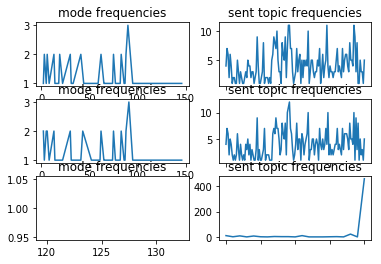

In [97]:
# all topics frequency distribution 
import matplotlib.pyplot as plt

topic_models_list = [i for i in df.columns if i.endswith('_mode')]
# topic_models_list.remove('lda_random_projections_topic_mode')
fig, axes = plt.subplots(len(topic_models_list), 2)

for i, model in enumerate(topic_models_list):
    topic_freqs = df[model].value_counts().sort_index().plot(ax=axes[i, 0], title='mode frequencies')
    pd_topic_frequencies = df[model+'_prob'].apply(lambda x: pd.Series(x.split(',')).value_counts()).fillna(0)
    topic_sent_freqs = pd_topic_frequencies.sum().sort_index().plot(ax=axes[i, 1], title='sent topic frequencies')

plt.show()

In [89]:
df.lda_5_topic_mode.value_counts()

0    5272
4    4657
3    4108
2    3181
1    1802
Name: lda_5_topic_mode, dtype: int64

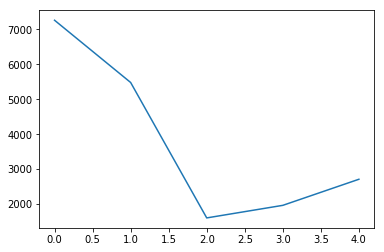

In [32]:
df.lda_topic_mode.value_counts().sort_index().plot()

In [17]:
pd_topic_frequencies = df.lda_topic_mode_prob.apply(lambda x: pd.Series(x.split(',')).value_counts()).fillna(0)
pd_topic_frequencies.head()

,1,2,0,4,3
0,4.0,3.0,2.0,2.0,0.0
1,3.0,1.0,0.0,1.0,0.0
2,2.0,1.0,5.0,5.0,1.0
3,7.0,10.0,7.0,5.0,5.0
4,3.0,0.0,4.0,1.0,2.0


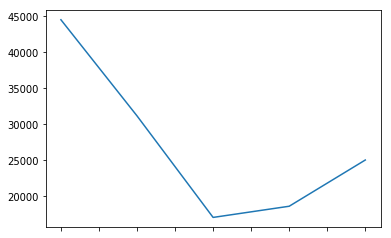

In [33]:
pd_topic_frequencies.sum().sort_index().plot()

## Topics Models

In [45]:
import itertools
import ast
df = pd.read_csv('../../data/processed/yp_competitors_rws_0001_0050_complete.csv')
revs = df.norm_tokens_doc[:1000].apply(lambda x: ast.literal_eval(x))
docs = list(itertools.chain(*revs))

In [52]:
from gensim.models import LdaModel
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

id2word = Dictionary(docs)

lda_model_list = []
coherence_list = []
for num_topics in range(2, 21, 3):
    model_path = f'../../model/lda_model/lda_{num_topics}.model'
    lda_model = LdaModel.load(model_path)
    lda_model_list.append(lda_model)
    
    coherencemodel = CoherenceModel(model=lda_model, corpus=id2word, texts=revs)
    coherence_list.append(coherencemodel)

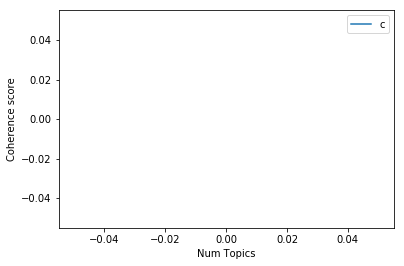

In [50]:
# to select number of topics
import matplotlib.pyplot as plt
x = range(2, 21, 3)
plt.plot(x, coherence_list)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [85]:
lda_model_list = []
coherence_list = []
for num_topics in range(2, 21, 3):
    model_path = f'../../model/lda_model/lda_{num_topics}.model'
    lda_model = LdaModel.load(model_path)
    lda_model_list.append(lda_model)
    
    print(lda_model.show_topics(num_words=3, formatted=False))
    print()

[(0, [("'s", 0.021545552), ("n't", 0.016875122), ('place', 0.014476066)]), (1, [('food', 0.030332288), ('good', 0.027460653), ('pizza', 0.026512817)])]

[(0, [("'s", 0.027047807), ('place', 0.02599774), ('time', 0.024431953)]), (1, [('tabl', 0.019681472), ('wait', 0.019004581), ('u', 0.018973699)]), (2, [("n't", 0.029451376), ("'s", 0.023170928), ('like', 0.020852951)]), (3, [('food', 0.07399063), ('great', 0.07250713), ('good', 0.046826713)]), (4, [('pizza', 0.048294157), ('ice', 0.022055563), ('order', 0.02117493)])]

[(0, [('time', 0.031378828), ('back', 0.03072236), ('maui', 0.030653413)]), (1, [('good', 0.11242844), ('realli', 0.026901444), ('salad', 0.022591224)]), (2, [("'s", 0.033723466), ('like', 0.020568809), ("n't", 0.019035518)]), (3, [('food', 0.090099655), ('great', 0.080942355), ('servic', 0.044482343)]), (4, [('pizza', 0.09317499), ('ice', 0.042550944), ('like', 0.029364688)]), (5, [('order', 0.039199546), ('husband', 0.029179899), ('bob', 0.026805798)]), (6, [('u', 0.0

In [ ]:
prin